# **Importing the required libraries**

In [1]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow 
import keras
from collections import deque
import matplotlib.pyplot as plt
plt.style.use("seaborn")
%matplotlib inline

In [2]:
import imageio
import imgaug.augmenters as iaa
import imgaug as ia

In [3]:
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

# **Visualize the Data**

In [4]:
# Classes Directories
NonViolenceVideos_Dir = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/"
ViolenceVideos_Dir = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/"

# Retrieve the list of all the video files present in the Class Directory.
NonViolence_files_names_list = os.listdir(NonViolenceVideos_Dir)
Violence_files_names_list = os.listdir(ViolenceVideos_Dir)

# Randomly select a video file from the Classes Directory.
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)

# **Extracting Frames**

In [5]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 15
 

DATASET_DIR = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/"
 
CLASSES_LIST = ["NonViolence","Violence"]

In [6]:
def frames_extraction(video_path):
 
    frames_list = []
    
    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)
 
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
 
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Reading the frame from the video. 
        success, image = video_reader.read() 
        
        # Apply image augmentation
        
        #flip = iaa.Fliplr(1.0)
        zoom = iaa.Affine(scale=1.3)
        random_brightness = iaa.Multiply((1, 1.3))
        #rotate = iaa.Affine(rotate=(-25, 25))
                
        #image_aug = flip(image = image)
        image_aug = random_brightness(image = image)
        image_aug = zoom(image = image_aug)
        #image_aug = rotate(image = image_aug)
        
        if not success:
            break
 
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(image_aug, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
 
    video_reader.release()
 
    return frames_list

# **Creating the Dataset**

In [7]:
def create_dataset():
 
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes.
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        # 
        for file_name in files_list[:300]: # specific number video per class
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
 
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels, video_files_paths

In [8]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: NonViolence
Extracting Data of Class: Violence


# **Encoding and Splitting Training-Testing Sets**

In [9]:
# convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [10]:
# Split the Data into Train ( 80% ) and Test Set ( 20% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2,
                                                                            shuffle = True, random_state = 42)

In [11]:
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

(480, 15, 64, 64, 3) (480, 2)
(120, 15, 64, 64, 3) (120, 2)


# **Importing MobileNet and Fine-Tuning it.**

In [12]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2(include_top=False , weights="imagenet")

#Fine-Tuning to make the last 40 layer trainable
mobilenet.trainable=True

for layer in mobilenet.layers[:-40]:
    layer.trainable=False

9406464/9406464 [==============================] - 0s 0us/step


# **Building The Model**

In [13]:
def create_model():
     
    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)  
    optimizers = tf.keras.optimizers
    
    model = Sequential([

    ########################################################################################################################
    
    #Specifying Input to match features shape
    Input(shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    
    # Passing mobilenet in the TimeDistributed layer to handle the sequence
    TimeDistributed(mobilenet),
    Dropout(0.25),              
    # Time distributed
    TimeDistributed(Flatten()),
    
    Bidirectional(lstm_fw, backward_layer = lstm_bw),
    Dropout(0.25),
        # Layer 1
    Dense(256,activation='relu'),
    Dropout(0.25),
        # Layer 3
    Dense(64,activation='relu'),
    Dropout(0.25),
        #  Layer 4
    Dense(32,activation='relu'),
    Dropout(0.25),
        # #Layer 1
        # softmax
    Dense(len(CLASSES_LIST), activation = 'sigmoid')
    ])
    
    adam = optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss="binary_crossentropy", optimizer=adam,metrics=["accuracy"])
    # Compiling the model 
    #model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])
    ########################################################################################################################
 
    model.summary()
    
    return model

In [14]:
MoBiLSTM_model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 2, 2, 1280)   2257984   
 ibuted)                                                         
                                                                 
 dropout (Dropout)           (None, 15, 2, 2, 1280)    0         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 5120)         0         
 tributed)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 64)               1319168   
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

# **Specifying Callbacks and Fitting**

In [15]:
patience = 5

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.0005

batch_size = 8
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)


In [16]:
# Create Early Stopping Callback to monitor the accuracy
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', 
                                        patience = 10,restore_best_weights=True)

# Create checkpoint for model
# Change name for model

checkpoint_filepath = 'ModelWeights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                                  factor=0.8,
                                                  patience=3,
                                                  #min_lr=0.0001,
                                                  verbose=1)
callbacks = [lr_callback, early_stopping_callback, reduce_lr]

In [17]:
# Fitting the model 
MobBiLSTM_model_history = MoBiLSTM_model.fit(x = features_train, y = labels_train, epochs = 20, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2, callbacks = callbacks)

Epoch 1/20
48/48 [==============================] - 25s 99ms/step - loss: 0.6994 - accuracy: 0.5026 - val_loss: 0.6911 - val_accuracy: 0.5625 - lr: 1.0000e-05
Epoch 2/20
48/48 [==============================] - 2s 51ms/step - loss: 0.6935 - accuracy: 0.5078 - val_loss: 0.6900 - val_accuracy: 0.5625 - lr: 1.0800e-04
Epoch 3/20
48/48 [==============================] - 2s 51ms/step - loss: 0.6824 - accuracy: 0.5729 - val_loss: 0.6732 - val_accuracy: 0.6042 - lr: 2.0600e-04
Epoch 4/20
48/48 [==============================] - 3s 52ms/step - loss: 0.6297 - accuracy: 0.6927 - val_loss: 0.5972 - val_accuracy: 0.6771 - lr: 3.0400e-04
Epoch 5/20
48/48 [==============================] - 3s 53ms/step - loss: 0.5636 - accuracy: 0.7474 - val_loss: 0.5974 - val_accuracy: 0.6875 - lr: 4.0200e-04
Epoch 6/20
48/48 [==============================] - 2s 51ms/step - loss: 0.4184 - accuracy: 0.8359 - val_loss: 0.6085 - val_accuracy: 0.6875 - lr: 5.0000e-04
Epoch 7/20
48/48 [==============================] -

In [18]:
model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)

4/4 [==============================] - 3s 111ms/step - loss: 0.5225 - accuracy: 0.8833


# **Model Evaluation**

In [19]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Get the Epochs Count
    epochs = range(len(metric_value_1))
 
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)
 
    plt.title(str(plot_name))
 
    plt.legend()

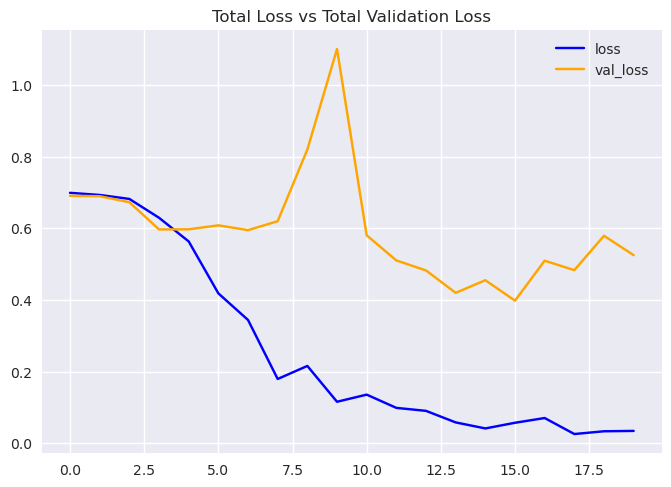

In [20]:
plot_metric(MobBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

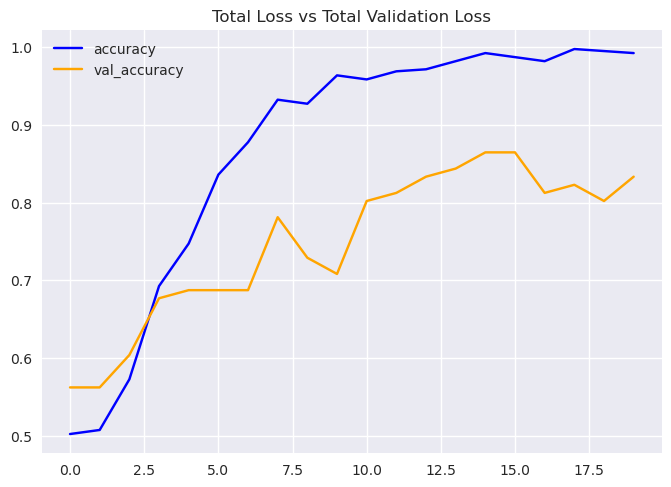

In [21]:
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

# **Predicting the Test Set**

In [22]:
labels_predict = MoBiLSTM_model.predict(features_test)

4/4 [==============================] - 2s 38ms/step


In [23]:
# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [24]:
labels_test_normal.shape , labels_predict.shape

((120,), (120,))

# **Accuracy Score**

In [25]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.8833333333333333


# Confusion Matrix

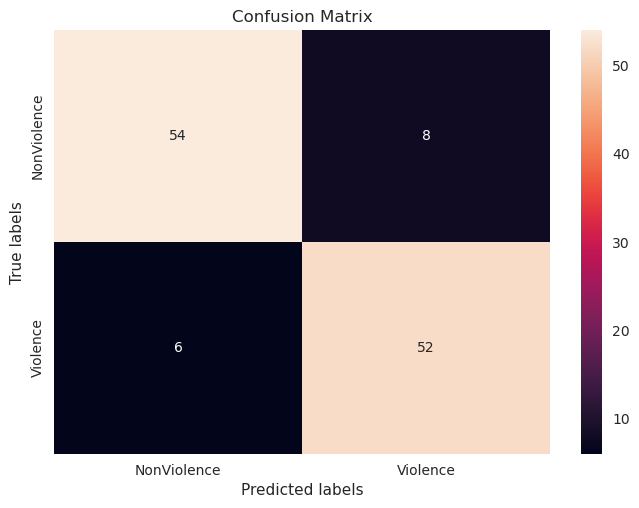

In [26]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['NonViolence', 'Violence']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

# **Classification Report**

In [27]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.90      0.87      0.89        62
           1       0.87      0.90      0.88        58

    accuracy                           0.88       120
   macro avg       0.88      0.88      0.88       120
weighted avg       0.88      0.88      0.88       120



# **Prediction Frame By Frame**

In [28]:
def predict_frames(video_file_path, output_file_path, SEQUENCE_LENGTH):
    
    # Read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # VideoWriter to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 
                                    video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
 
    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
 
    # Store the predicted class in the video.
    predicted_class_name = ''
 
    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():
 
        ok, frame = video_reader.read() 
        
        if not ok:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame 
        normalized_frame = resized_frame / 255
 
        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)
 
        # We Need at Least number of SEQUENCE_LENGTH Frames to perform a prediction.
        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:                        
 
            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_queue, axis = 0))[0]
 
            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)
 
            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]
 
        # Write predicted class name on top of the frame.
        if predicted_class_name == "Violence":
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 12)
        else:
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 12)
         
        # Write The frame into the disk using the VideoWriter
        video_writer.write(frame)                       
        
    video_reader.release()
    video_writer.release()

In [29]:
plt.style.use("default")

# To show Random Frames from the saved output predicted video (output predicted video doesn't show on the notebook but can be downloaded)
def show_pred_frames(pred_video_path): 

    plt.figure(figsize=(20,15))

    video_reader = cv2.VideoCapture(pred_video_path)

    # Get the number of frames in the video.
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Get Random Frames from the video then Sort it
    random_range = sorted(random.sample(range (SEQUENCE_LENGTH , frames_count ), 12))
        
    for counter, random_index in enumerate(random_range, 1):
        
        plt.subplot(5, 4, counter)

        # Set the current frame position of the video.  
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)
          
        ok, frame = video_reader.read() 

        if not ok:
            break 

        frame = cv2.cvtColor(frame , cv2.COLOR_BGR2RGB)

        plt.imshow(frame);ax.figure.set_size_inches(20,20);plt.tight_layout()
                            
    video_reader.release()

In [30]:
# Construct the output video path.
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)
 
output_video_file_path = f'{test_videos_directory}/Output-Test-Video.mp4'

1/1 [==============================] - 0s 27ms/step


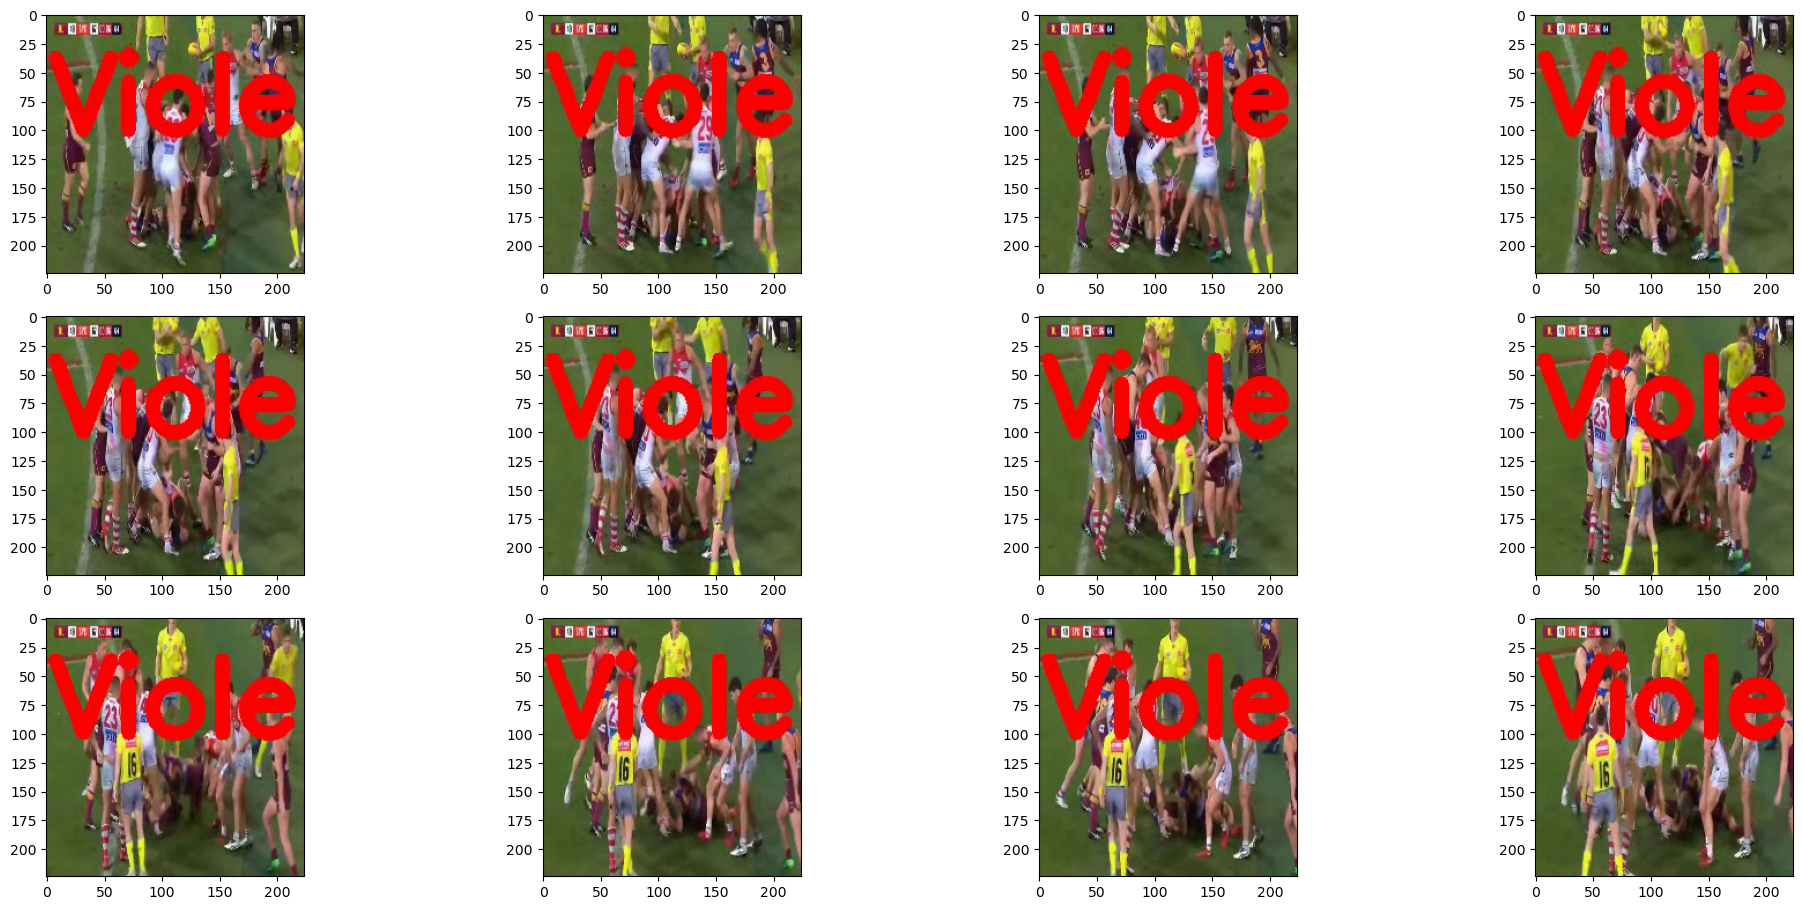

In [31]:
# Specifying video to be predicted
input_video_file_path = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_670.mp4"

# Perform Prediction on the Test Video.
predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Show random frames from the output video
show_pred_frames(output_video_file_path)

1/1 [==============================] - 0s 26ms/step


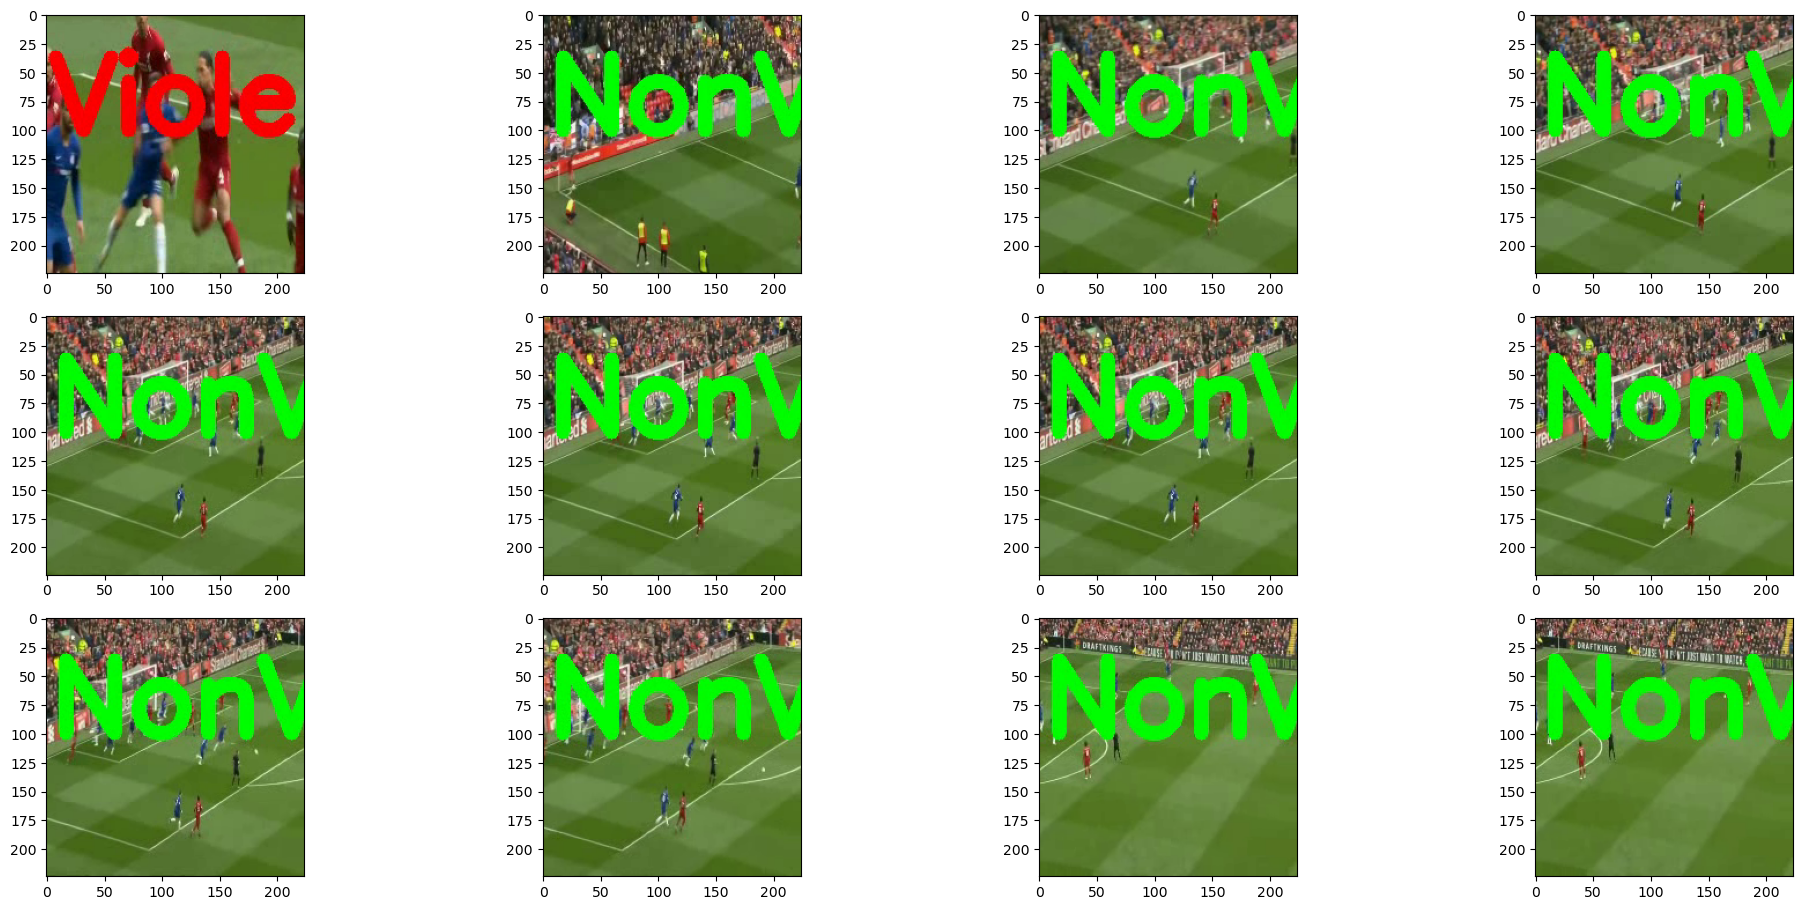

In [33]:
# Specifying video to be predicted
input_video_file_path = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_102.mp4"

# Perform Prediction on the Test Video.
predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Show random frames from the output video
show_pred_frames(output_video_file_path)

# **Prediction For The Video**

In [37]:
def predict_video(video_file_path, SEQUENCE_LENGTH):
 
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Store the predicted class in the video.
    predicted_class_name = ''
 
    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
 
    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        success, frame = video_reader.read() 
 
        if not success:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame.
        normalized_frame = resized_frame / 255
        
        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)
 
    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_list, axis = 0))[0]
 
    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)
 
    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Display the predicted class along with the prediction confidence.
    print(f'Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    video_reader.release()

In [38]:
# Specifying video to be predicted
input_video_file_path = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_276.mp4"

# Perform Single Prediction on the Test Video.
predict_video(input_video_file_path, SEQUENCE_LENGTH)

# Play the actual video
Play_Video(input_video_file_path)

1/1 [==============================] - 0s 29ms/step
Predicted: Violence
Confidence: 0.9865096211433411


In [39]:
# Specifying video to be predicted
input_video_file_path = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_23.mp4"

# Perform Single Prediction on the Test Video.
predict_video(input_video_file_path, SEQUENCE_LENGTH)

# Play the actual video
Play_Video(input_video_file_path)

1/1 [==============================] - 0s 26ms/step
Predicted: NonViolence
Confidence: 0.9979583024978638
